# Aprendizaje por Refuerzo I - TP (17Co2024)

#### Alumno
- Ignacio Tomas De Pedro Mermier

---

En este trabajo se estudia y compara el rendimiento de los algoritmos de **Q-Learning** y **Deep Q-Learning** en el entorno *FrozenLake* de la librería *Gymnasium*. Se implementa además un mecanismo de grid search para la optimización los hiperparámetros en ambos métodos. Los resultados serán evaluados bajo distintas métricas que permitirán establecer una comparación entre los mismos.

**Importar librerias necesarias**

In [137]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from itertools import product
import time
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

**Parámetros de configuración para los gráficos**

In [67]:
plt.rcParams.update({
    'figure.facecolor': '#2b2b2b',     # fondo exterior
    'axes.facecolor':   '#2b2b2b',     # fondo del área del gráfico
    'axes.edgecolor':   '#cccccc',     # borde de los ejes
    'axes.labelcolor':  '#cccccc',     # etiquetas de los ejes
    'xtick.color':      '#cccccc',     # color de los números en el eje X
    'ytick.color':      '#cccccc',     # color de los números en el eje Y
    'text.color':       '#cccccc',     # color del título y textos
    'grid.color':       '#444444',     # color de la grilla
})


# Q-learning

Inicialmente, vamos a empezar trabajando con el ejemplo visto en clase de Q-learning sobre el entorno de Frozen-Lake 4x4. En la siguiente funcion se explora el algoritmo de Q-learning utilizado una tasa de aprendizaje ($\alpha$) de 0.1 y un factor de descuento ($\gamma$) de 0.9. A su vez, como se utiliza la estrategia epsilon-greedy, que permite establecer un equilibrio entre la exploración y la explotación, se define una tasa de decrecimiento de 0.0005 bajo un comportamiento exponencial.

In [98]:
# -*- coding: utf-8 -*-
def run_q_learning_frozen_lake_4x4(episodes, learning_rate_a=0.1, discount_factor_g=0.9, is_training=True, render=False, is_slippery = False,max_steps_per_episode = 100,verbose = False):

    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None,max_episode_steps=max_steps_per_episode)

    if(is_training):
        q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array
    else:
        with open('ql_frozen_lake4x4.pkl', 'rb') as f:
            q = pickle.load(f)

    # Exploración (Epsilon-Greedy)
    epsilon = 1.0              # Tasa de exploración inicial (100% aleatorio)
    max_epsilon = 1.0          # Máximo valor de epsilon
    min_epsilon = 0.01         # Mínimo valor de epsilon
    epsilon_decay_rate = 0.0005 # Tasa de decaimiento de epsilon por episodio

    rng = np.random.default_rng()

    # Para reporte/gráficas
    report_interval = episodes // 20 # Cada cuántos episodios mostrar progreso
    moving_avg_window = 100    # Ventana para la media móvil en la gráfica

    # Estructuras para guardar recompensas y pasos por episodio
    rewards_all_episodes = []
    steps_all_episodes = []

   
    if verbose:
        print(f"--- Iniciando Entrenamiento Q-Learning ---")
        print(f"Entorno: FrozenLake-v1 (4x4, {'Estocástico' if is_slippery else 'Determinista'})")
        print(f"Estados: {env.observation_space.n}, Acciones: {env.action_space.n}")
        print(f"Parámetros: α={learning_rate_a}, γ={discount_factor_g}, ε-decay={epsilon_decay_rate}")
        print(f"Episodios: {episodes}")
        print("-" * 40)

    start_time = time.time()

    for episode in range(episodes):

        # reiniciar el entorno
        state,info = env.reset()  
        terminated = False      
        truncated = False
        total_reward_episode = 0
        steps_episode = 0   

        while(not terminated and not truncated):
            # 1. Elegir accion (epsilon-greedy) solamente durante entrenamiento
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample() 
            else:
                action = np.argmax(q[state,:])
            
            # 2. Ejecutar accion
            new_state,reward,terminated,truncated,info = env.step(action)


            # 3. Actualizo el estado
            if is_training:
                q[state,action] = q[state,action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action]
                )

            state = new_state
            total_reward_episode += reward
            steps_episode += 1

        # 4. Decaimiento de Epsilon (exponencial)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode)

        # 5. Guardo informacion
        rewards_all_episodes.append(total_reward_episode)
        steps_all_episodes.append(steps_episode)
        
        # 6. Reportar progreso
        if verbose:
            if (episode + 1) % report_interval == 0:
                # Calcular tasa de éxito reciente
                recent_episodes = rewards_all_episodes[-report_interval:]
                success_rate = np.mean([1 if r > 0 else 0 for r in recent_episodes]) * 100
                avg_steps = np.mean(steps_all_episodes[-report_interval:])
                print(f"Episodio: {episode+1:>5}/{episodes} | "
                    f"Tasa Éxito (últimos {report_interval}): {success_rate:>6.2f}% | "
                    f"Pasos Prom (últimos {report_interval}): {avg_steps:>6.1f} | "
                    f"Epsilon: {epsilon:.3f}")

   
    env.close()
    end_time = time.time()
    elapsed_time = end_time - start_time
    if verbose:
        print("-" * 40)
        print(f"Entrenamiento finalizado en {end_time - start_time:.2f} segundos.")
        print("-" * 40)

    # 7. Guardar modelo en un archivo pickle
    if is_training:
        f = open("ql_frozen_lake4x4.pkl","wb")
        pickle.dump(q, f)
        f.close()
    
    return q,rewards_all_episodes, steps_all_episodes, elapsed_time



Al finalizar podemos observar la trayectoria aprendida, junto con las métricas de tasa de éxito, pasos promedio y tiempo total:
- Al ser un ambiente relativamente sencillo, ya que tiene unicamente 16 estados, el tiempo de aprendizaje es bastante bajo: 1.12 segundos.
- La tasa de éxito es relativamente alta, 88%, lo que indica que aprende en mucho menos episodios que los 20000 establecidos.
- El promedio de pasos es muy bajo, lo que indica que el modelo converge a una trayectoria óptima en muchos menos episodios que los 20000 establecidos. 

In [160]:
_,_,_,_ = run_q_learning_frozen_lake_4x4(3, is_training=False, render=True)

In [94]:
q,rewards_all_episodes, steps_all_episodes, elapsed_time = run_q_learning_frozen_lake_4x4(episodes=20000,learning_rate_a=0.1,discount_factor_g=0.95)

success_rate = np.mean([1 if r > 0 else 0 for r in rewards_all_episodes]) * 100
avg_steps = np.mean(steps_all_episodes)
print(  f"Tasa Éxito: {success_rate:>6.2f}% | "
        f"Pasos Prom: {avg_steps:>6.1f} | "
        f"Tiempo total:{elapsed_time:.2f} segundos.")

Tasa Éxito:  88.00% | Pasos Prom:    6.2 | Tiempo total:1.12 segundos.


Si graficamos la tasa de éxito del modelo, se observa que a paritr de los 7500 episodios, la misma converge a un valor cercano al 100% lo que indica que el algoritmo ya aprendio correctamente el mapa y lo tien refleajo en su tabla Q.

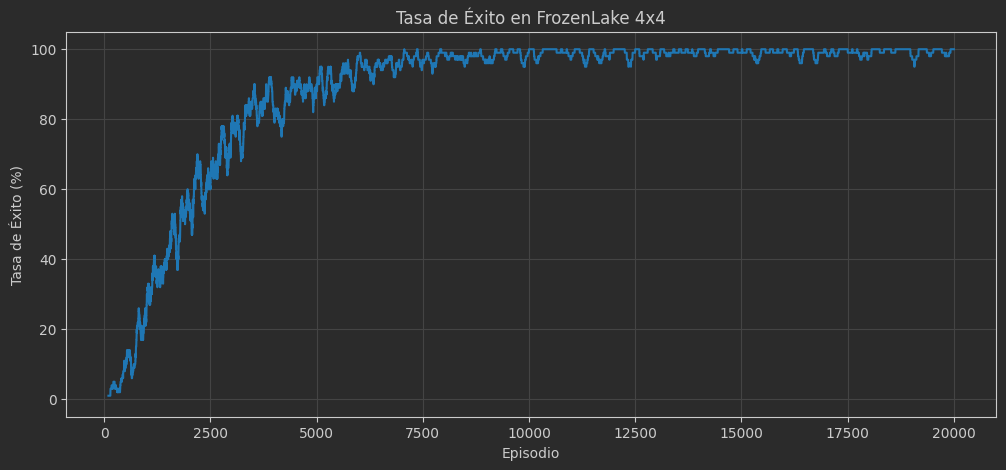

In [ ]:
# 1. Gráfica de Convergencia (Tasa de Éxito con Media Móvil)
moving_avg_window = 100    # Ventana para la media móvil en la gráfica
episodes = 20000
if len(rewards_all_episodes) >= moving_avg_window:
    # Calcular tasa de éxito (1 si recompensa > 0)
    success_rate_all = [1 if r > 0 else 0 for r in rewards_all_episodes]
    # Calcular media móvil
    moving_avg_success = np.convolve(success_rate_all, np.ones(moving_avg_window)/moving_avg_window, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(moving_avg_window - 1, episodes), moving_avg_success * 100)
    plt.title(f"Tasa de Éxito en FrozenLake 4x4")
    plt.xlabel("Episodio")
    plt.ylabel("Tasa de Éxito (%)")
    plt.grid(True)
    plt.ylim(-5, 105)
    plt.show()
else:
    print("No hay suficientes episodios para calcular la media móvil.")
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_all_episodes)
    plt.title("Recompensa por Episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa Total")
    plt.grid(True)
    plt.show()


## Optimización de Hiperparámetros

Dos de los hiperparámetros más importantes en el caso de **Q-Learning** son:

- *Learning Rate ($\alpha$):* controla cuánto se actualiza la función Q en cada paso de aprendizaje.  
  - Valores muy altos pueden hacer que el agente aprenda de forma inestable.  
  - Valores muy bajos pueden ralentizar el aprendizaje.

- *Discount Factor ($\gamma$):* determina cuánto peso se le da a las recompensas futuras frente a las inmediatas.  
  - Un valor cercano a 0 hace que el agente se enfoque en recompensas inmediatas.  
  - Un valor cercano a 1 hace que planifique a más largo plazo.

Dado que no existe un valor óptimo para estos parámetros para todos los casos, se utiliza la técnica de búsqueda sistemática **Grid Search**, que consiste en probar distintas combinaciones de valores y seleccionar aquella que maximice el desempeño del agente.

In [ ]:
def grid_search_q_learning_4x4(episodes=5000,verbose=False):
    learning_rates = [0.01, 0.05, 0.1, 0.5]
    discount_factors = [0.8, 0.9, 0.95, 0.99]

    results = {}

    for lr, gamma in product(learning_rates, discount_factors):
        print(f"Ejecutando con lr={lr}, gamma={gamma}...")
        q,rewards_all_episodes, steps_all_episodes, elapsed_time = run_q_learning_frozen_lake_4x4(episodes=episodes,learning_rate_a=lr,discount_factor_g=gamma,verbose=verbose)

        avg_reward_last100 = np.mean(rewards_all_episodes[-100:])
        success_rate = np.mean(rewards_all_episodes)  # tasa de éxito global

        avg_steps_last100 = np.mean(steps_all_episodes[-100:])
        steps_rate = np.mean(steps_all_episodes)  # tasa de éxito global
        print(f"   AvgRewardLast100={avg_reward_last100:.2f}, AvgRewardLast100={avg_steps_last100:.2f}")
        results[(lr, gamma)] = {
            "avg_reward_last100": avg_reward_last100,
            "success_rate": success_rate,
            "final_sum_reward": rewards_all_episodes[-1],
            "avg_step_last100": avg_steps_last100,
            "step_rate": steps_rate,
            "final_steps": steps_all_episodes[-1],
            "elapsed_time":elapsed_time
        }

    return results

In [169]:
results = grid_search_q_learning_4x4(episodes=2500)

Ejecutando con lr=0.01, gamma=0.8...
   AvgRewardLast100=0.64, AvgRewardLast100=6.08
Ejecutando con lr=0.01, gamma=0.9...
   AvgRewardLast100=0.73, AvgRewardLast100=7.02
Ejecutando con lr=0.01, gamma=0.95...
   AvgRewardLast100=0.61, AvgRewardLast100=6.34
Ejecutando con lr=0.01, gamma=0.99...
   AvgRewardLast100=0.54, AvgRewardLast100=6.72
Ejecutando con lr=0.05, gamma=0.8...
   AvgRewardLast100=0.63, AvgRewardLast100=6.62
Ejecutando con lr=0.05, gamma=0.9...
   AvgRewardLast100=0.68, AvgRewardLast100=6.65
Ejecutando con lr=0.05, gamma=0.95...
   AvgRewardLast100=0.69, AvgRewardLast100=6.94
Ejecutando con lr=0.05, gamma=0.99...
   AvgRewardLast100=0.57, AvgRewardLast100=6.37
Ejecutando con lr=0.1, gamma=0.8...
   AvgRewardLast100=0.71, AvgRewardLast100=6.51
Ejecutando con lr=0.1, gamma=0.9...
   AvgRewardLast100=0.67, AvgRewardLast100=6.43
Ejecutando con lr=0.1, gamma=0.95...
   AvgRewardLast100=0.60, AvgRewardLast100=6.77
Ejecutando con lr=0.1, gamma=0.99...
   AvgRewardLast100=0.60, 

In [ ]:
# Mostrar resultados ordenados
sorted_results_4x4 = sorted(results.items(), key=lambda x: x[1]['avg_reward_last100'], reverse=True)
for (lr, gamma), metrics in sorted_results_4x4:
    print(f"lr={lr}, gamma={gamma} -> AvgRewardLast100={metrics['avg_reward_last100']:.2f}, "
            f"AvgRewardLast100={metrics['avg_step_last100']:.2f}")

lr=0.01, gamma=0.9 -> AvgRewardLast100=0.73, AvgRewardLast100=7.02
lr=0.1, gamma=0.8 -> AvgRewardLast100=0.71, AvgRewardLast100=6.51
lr=0.5, gamma=0.99 -> AvgRewardLast100=0.71, AvgRewardLast100=6.48
lr=0.5, gamma=0.95 -> AvgRewardLast100=0.70, AvgRewardLast100=6.52
lr=0.05, gamma=0.95 -> AvgRewardLast100=0.69, AvgRewardLast100=6.94
lr=0.05, gamma=0.9 -> AvgRewardLast100=0.68, AvgRewardLast100=6.65
lr=0.1, gamma=0.9 -> AvgRewardLast100=0.67, AvgRewardLast100=6.43
lr=0.01, gamma=0.8 -> AvgRewardLast100=0.64, AvgRewardLast100=6.08
lr=0.5, gamma=0.9 -> AvgRewardLast100=0.64, AvgRewardLast100=6.41
lr=0.05, gamma=0.8 -> AvgRewardLast100=0.63, AvgRewardLast100=6.62
lr=0.5, gamma=0.8 -> AvgRewardLast100=0.63, AvgRewardLast100=6.38
lr=0.01, gamma=0.95 -> AvgRewardLast100=0.61, AvgRewardLast100=6.34
lr=0.1, gamma=0.95 -> AvgRewardLast100=0.60, AvgRewardLast100=6.77
lr=0.1, gamma=0.99 -> AvgRewardLast100=0.60, AvgRewardLast100=6.53
lr=0.05, gamma=0.99 -> AvgRewardLast100=0.57, AvgRewardLast100=6

Al analizar los resultados obtenidos al aplicar **Grid Search** sobre los hiperparámetros *learning rate (α)* y *discount factor (γ)* en el entorno *FrozenLake 4x4*:

- La mejor combinación encontrada fue $\alpha=0.01$ y $\gamma=0.9$, alcanzando:
  - **Recompensa promedio en los últimos 100 episodios ≈ 0.73**  
  - **Recompensa acumulada ≈ 7.02**

- Otras combinaciones también mostraron un rendimiento competitivo, por ejemplo:
  - **α=0.1, γ=0.8** con promedio ≈ 0.71  
  - **α=0.5, γ=0.99** con promedio ≈ 0.71  

  Es importante aclarar que para esta prueba se utlizaron unicamente 5000 episodios ya que buscabamos la combinacion que más rápido converga al 100%. Si se toma un valor muy alto de episodios, los últimos 100 casos seguramente van a ser todos exitososo, lo que genera que la comparación no sea muy útil.

### Conclusión

La optimización de hiperparámetros permitió mejorar el desempeño del agente Q-Learning, alcanzando una **tasa de éxito cercana al 73% en los últimos episodios**. Estos resultados muestran la importancia de ajustar correctamente α y γ, ya que valores inadecuados pueden reducir de forma significativa la capacidad de aprendizaje del agente.




In [ ]:
# 1. Gráfica de Convergencia (Tasa de Éxito con Media Móvil)
moving_avg_window = 100    # Ventana para la media móvil en la gráfica
episodes = 2500
if len(rewards_all_episodes) >= moving_avg_window:
    # Calcular tasa de éxito (1 si recompensa > 0)
    success_rate_all = [1 if r > 0 else 0 for r in rewards_all_episodes]
    # Calcular media móvil
    moving_avg_success = np.convolve(success_rate_all, np.ones(moving_avg_window)/moving_avg_window, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(moving_avg_window - 1, episodes), moving_avg_success * 100)
    plt.title(f"Tasa de Éxito en FrozenLake 4x4")
    plt.xlabel("Episodio")
    plt.ylabel("Tasa de Éxito (%)")
    plt.grid(True)
    plt.ylim(-5, 105)
    plt.show()
else:
    print("No hay suficientes episodios para calcular la media móvil.")
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_all_episodes)
    plt.title("Recompensa por Episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa Total")
    plt.grid(True)
    plt.show()


## FrozenLake 8x8

Para analizar el comportamiento de Q-learning de manera mas exhaustiva, se utiliza una expansion del ambiente de frozenlake de 4x4 a 8x8, para observar la performance del modelo en un ambiente significativamente más grande. 

En este caso, como la cantidad de episodios crece de manera significativa con respecto al caso anterior (por el aumento de los estados posibles), el valor de epsilon se obtiene mediante la inversa de la cantidad de episodios y no es una constante como en el caso anterior. Esto me permite realizar pruebas manuales, aumentando la cantidad de episodios hasta alcanzar una tasa de éxito razonable, sin considerar un valor de epsilon fijo.

In [172]:
# -*- coding: utf-8 -*-
def run_q_learning_frozen_lake_8x8(episodes, learning_rate_a=0.1, discount_factor_g=0.9, is_training=True, render=False, is_slippery = False,max_steps_per_episode = 100,verbose = False):

    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=is_slippery, render_mode='human' if render else None,max_episode_steps=max_steps_per_episode)

    if(is_training):
        q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array
    else:
        with open('ql_frozen_lake8x8.pkl', 'rb') as f:
            q = pickle.load(f)

    # Exploración (Epsilon-Greedy)
    epsilon = 1.0              # Tasa de exploración inicial (100% aleatorio)
    max_epsilon = 1.0          # Máximo valor de epsilon
    min_epsilon = 0.01         # Mínimo valor de epsilon
    epsilon_decay_rate = 1/episodes # Tasa de decaimiento de epsilon por episodio

    rng = np.random.default_rng()

    # Para reporte/gráficas
    report_interval = episodes // 20 # Cada cuántos episodios mostrar progreso
    moving_avg_window = 100    # Ventana para la media móvil en la gráfica

    # Estructuras para guardar recompensas y pasos por episodio
    rewards_all_episodes = []
    steps_all_episodes = []

   
    if verbose:
        print(f"--- Iniciando Entrenamiento Q-Learning ---")
        print(f"Entorno: FrozenLake-v1 (8x8, {'Estocástico' if is_slippery else 'Determinista'})")
        print(f"Estados: {env.observation_space.n}, Acciones: {env.action_space.n}")
        print(f"Parámetros: α={learning_rate_a}, γ={discount_factor_g}, ε-decay={epsilon_decay_rate}")
        print(f"Episodios: {episodes}")
        print("-" * 40)

    start_time = time.time()

    for episode in range(episodes):

        # reiniciar el entorno
        state,info = env.reset()  
        terminated = False      
        truncated = False
        total_reward_episode = 0
        steps_episode = 0   

        while(not terminated and not truncated):
            # 1. Elegir accion (epsilon-greedy) solamente durante entrenamiento
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample() 
            else:
                action = np.argmax(q[state,:])
            
            # 2. Ejecutar accion
            new_state,reward,terminated,truncated,info = env.step(action)


            # 3. Actualizo el estado
            if is_training:
                q[state,action] = q[state,action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action]
                )

            state = new_state
            total_reward_episode += reward
            steps_episode += 1

        # 4. Decaimiento de Epsilon (exponencial)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode)
        epsilon = max(epsilon - epsilon_decay_rate, 0)
        # 5. Guardo informacion
        rewards_all_episodes.append(total_reward_episode)
        steps_all_episodes.append(steps_episode)
        
        # 6. Reportar progreso
        if verbose:
            if (episode + 1) % report_interval == 0:
                # Calcular tasa de éxito reciente
                recent_episodes = rewards_all_episodes[-report_interval:]
                success_rate = np.mean([1 if r > 0 else 0 for r in recent_episodes]) * 100
                avg_steps = np.mean(steps_all_episodes[-report_interval:])
                print(f"Episodio: {episode+1:>5}/{episodes} | "
                    f"Tasa Éxito (últimos {report_interval}): {success_rate:>6.2f}% | "
                    f"Pasos Prom (últimos {report_interval}): {avg_steps:>6.1f} | "
                    f"Epsilon: {epsilon:.3f}")

   
    env.close()
    end_time = time.time()
    elapsed_time = end_time - start_time
    if verbose:
        print("-" * 40)
        print(f"Entrenamiento finalizado en {end_time - start_time:.2f} segundos.")
        print("-" * 40)

    # 7. Guardar modelo en un archivo pickle
    if is_training:
        f = open("ql_frozen_lake8x8.pkl","wb")
        pickle.dump(q, f)
        f.close()
    
    return q,rewards_all_episodes, steps_all_episodes, elapsed_time

In [174]:
q,rewards_all_episodes, steps_all_episodes, elapsed_time = run_q_learning_frozen_lake_8x8(episodes=200000,learning_rate_a=0.1,discount_factor_g=0.9,verbose=True)

--- Iniciando Entrenamiento Q-Learning ---
Entorno: FrozenLake-v1 (8x8, Determinista)
Estados: 64, Acciones: 4
Parámetros: α=0.1, γ=0.9, ε-decay=5e-06
Episodios: 200000
----------------------------------------
Episodio: 10000/200000 | Tasa Éxito (últimos 10000):   0.37% | Pasos Prom (últimos 10000):   31.9 | Epsilon: 0.952
Episodio: 20000/200000 | Tasa Éxito (últimos 10000):   1.03% | Pasos Prom (últimos 10000):   29.3 | Epsilon: 0.906
Episodio: 30000/200000 | Tasa Éxito (últimos 10000):   1.19% | Pasos Prom (últimos 10000):   27.1 | Epsilon: 0.862
Episodio: 40000/200000 | Tasa Éxito (últimos 10000):   1.19% | Pasos Prom (últimos 10000):   24.1 | Epsilon: 0.821
Episodio: 50000/200000 | Tasa Éxito (últimos 10000):   1.06% | Pasos Prom (últimos 10000):   21.5 | Epsilon: 0.781
Episodio: 60000/200000 | Tasa Éxito (últimos 10000):   1.22% | Pasos Prom (últimos 10000):   20.0 | Epsilon: 0.743
Episodio: 70000/200000 | Tasa Éxito (últimos 10000):   1.85% | Pasos Prom (últimos 10000):   19.1 | 

Al aumentar el tamaño del entorno de *FrozenLake* de 4x4 a 8x8, se observa que el aprendizaje del agente se vuelve mucho más lento y desafiante.  

En los primeros 100000 episodios, la tasa de éxito es muy baja (por debajo del 7%). Recién hacia los 20.000 episodios el agente alcanza alrededor de un 25% de éxito, lo que indica que necesita una gran cantidad de interacciones con el entorno para mejorar su desempeño.

Además, los pasos promedio por episodio disminuyen progresivamente de 32 a 15, aproximadamente, lo cual muestra que el agente efectivamente está aprendiendo caminos más cortos hacia el objetivo, aunque de manera muy gradual.

Estos resultados reflejan que al escalar el entorno, el espacio de estados se hace mucho más grande y complejo, lo que exige **más episodios y mejor ajuste de los hiperparámetros** para que el agente logre converger.

## Optimización de Hiperparámetros

Al igual que en el caso anterior, vamos realizar la optimización de los hiperparámetros más importantes:

- *Learning Rate ($\alpha$):* controla cuánto se actualiza la función Q en cada paso de aprendizaje.  

- *Discount Factor ($\gamma$):* determina cuánto peso se le da a las recompensas futuras frente a las inmediatas.  

In [ ]:
def grid_search_q_learning_8x8(episodes=200000,verbose=False):
    learning_rates = [0.01, 0.05, 0.1, 0.5]
    discount_factors = [0.8, 0.9, 0.95, 0.99]

    results = {}

    for lr, gamma in product(learning_rates, discount_factors):
        print(f"Ejecutando con lr={lr}, gamma={gamma}...")
        q,rewards_all_episodes, steps_all_episodes, elapsed_time = run_q_learning_frozen_lake_8x8(episodes=episodes,learning_rate_a=lr,discount_factor_g=gamma,verbose=verbose)

        avg_reward_last100 = np.mean(rewards_all_episodes[-100:])
        success_rate = np.mean(rewards_all_episodes)  # tasa de éxito global

        avg_steps_last100 = np.mean(steps_all_episodes[-100:])
        steps_rate = np.mean(steps_all_episodes)  # tasa de éxito global
        
        print(f"   AvgRewardLast100={avg_reward_last100:.2f}, AvgRewardLast100={avg_steps_last100:.2f}")
        
        results[(lr, gamma)] = {
            "avg_reward_last100": avg_reward_last100,
            "success_rate": success_rate,
            "final_sum_reward": rewards_all_episodes[-1],
            "avg_step_last100": avg_steps_last100,
            "step_rate": steps_rate,
            "final_steps": steps_all_episodes[-1],
            "elapsed_time":elapsed_time
        }

    return results

In [177]:
results = grid_search_q_learning_8x8(episodes=100000,verbose=False)

Ejecutando con lr=0.01, gamma=0.8...
   AvgRewardLast100=0.36, AvgRewardLast100=17.16
Ejecutando con lr=0.01, gamma=0.9...
   AvgRewardLast100=0.29, AvgRewardLast100=15.80
Ejecutando con lr=0.01, gamma=0.95...
   AvgRewardLast100=0.34, AvgRewardLast100=15.34
Ejecutando con lr=0.01, gamma=0.99...
   AvgRewardLast100=0.30, AvgRewardLast100=15.36
Ejecutando con lr=0.05, gamma=0.8...
   AvgRewardLast100=0.29, AvgRewardLast100=15.07
Ejecutando con lr=0.05, gamma=0.9...
   AvgRewardLast100=0.26, AvgRewardLast100=14.54
Ejecutando con lr=0.05, gamma=0.95...
   AvgRewardLast100=0.37, AvgRewardLast100=16.60
Ejecutando con lr=0.05, gamma=0.99...
   AvgRewardLast100=0.27, AvgRewardLast100=15.49
Ejecutando con lr=0.1, gamma=0.8...
   AvgRewardLast100=0.32, AvgRewardLast100=15.53
Ejecutando con lr=0.1, gamma=0.9...
   AvgRewardLast100=0.26, AvgRewardLast100=15.42
Ejecutando con lr=0.1, gamma=0.95...
   AvgRewardLast100=0.27, AvgRewardLast100=15.24
Ejecutando con lr=0.1, gamma=0.99...
   AvgRewardLas

In [178]:
# Mostrar resultados ordenados
sorted_results_8x8 = sorted(results.items(), key=lambda x: x[1]['avg_reward_last100'], reverse=True)
for (lr, gamma), metrics in sorted_results_8x8:
    print(f"lr={lr}, gamma={gamma} -> AvgRewardLast100={metrics['avg_reward_last100']:.2f}, "
            f"AvgRewardLast100={metrics['avg_step_last100']:.2f}")

lr=0.05, gamma=0.95 -> AvgRewardLast100=0.37, AvgRewardLast100=16.60
lr=0.01, gamma=0.8 -> AvgRewardLast100=0.36, AvgRewardLast100=17.16
lr=0.1, gamma=0.99 -> AvgRewardLast100=0.35, AvgRewardLast100=16.48
lr=0.01, gamma=0.95 -> AvgRewardLast100=0.34, AvgRewardLast100=15.34
lr=0.1, gamma=0.8 -> AvgRewardLast100=0.32, AvgRewardLast100=15.53
lr=0.01, gamma=0.99 -> AvgRewardLast100=0.30, AvgRewardLast100=15.36
lr=0.01, gamma=0.9 -> AvgRewardLast100=0.29, AvgRewardLast100=15.80
lr=0.05, gamma=0.8 -> AvgRewardLast100=0.29, AvgRewardLast100=15.07
lr=0.05, gamma=0.99 -> AvgRewardLast100=0.27, AvgRewardLast100=15.49
lr=0.1, gamma=0.95 -> AvgRewardLast100=0.27, AvgRewardLast100=15.24
lr=0.5, gamma=0.8 -> AvgRewardLast100=0.27, AvgRewardLast100=14.90
lr=0.05, gamma=0.9 -> AvgRewardLast100=0.26, AvgRewardLast100=14.54
lr=0.1, gamma=0.9 -> AvgRewardLast100=0.26, AvgRewardLast100=15.42
lr=0.5, gamma=0.95 -> AvgRewardLast100=0.21, AvgRewardLast100=14.88
lr=0.5, gamma=0.9 -> AvgRewardLast100=0.19, Avg

Tras aplicar *Grid Search* sobre los hiperparámetros *learning rate* ($\alpha$) y *discount factor* ($\gamma$), se obtuvieron los siguientes resultados:

- La mejor combinación encontrada fue **$\alpha$=0.05 y $\gamma$=0.95**, con una recompensa promedio en los últimos 100 episodios 37%.  
- Otras configuraciones también mostraron rendimientos cercanos, como:
  - **$\alpha$=0.01, $\gamma$=0.8** con promedio ≈ 0.36  
  - **$\alpha$=0.1, $\gamma$=0.99** con promedio ≈ 0.35  

### Conclusión

La búsqueda sistemática de hiperparámetros confirmó que el desempeño del agente mejora de forma considerable al elegir correctamente **$\alpha$ y $\gamma$**.  
En el caso de **FrozenLake 8x8**, la mejor combinación fue **$\alpha$=0.05, $\gamma$=0.95**, que permitió obtener una recompensa promedio notablemente mayor en comparación con configuraciones no optimizadas.

In [ ]:
# Entrenamos una vez mas con los valores optimos
(lr_opt,gamma_opt),metrics_opt = sorted_results_8x8[0]

q,rewards_all_episodes, steps_all_episodes, elapsed_time = run_q_learning_frozen_lake_8x8(episodes=200000,learning_rate_a=lr_opt,discount_factor_g=gamma_opt,verbose=True)


--- Iniciando Entrenamiento Q-Learning ---
Entorno: FrozenLake-v1 (8x8, Determinista)
Estados: 64, Acciones: 4
Parámetros: α=0.05, γ=0.95, ε-decay=5e-06
Episodios: 200000
----------------------------------------
Episodio: 10000/200000 | Tasa Éxito (últimos 10000):   0.24% | Pasos Prom (últimos 10000):   32.0 | Epsilon: 0.952
Episodio: 20000/200000 | Tasa Éxito (últimos 10000):   0.73% | Pasos Prom (últimos 10000):   32.1 | Epsilon: 0.906
Episodio: 30000/200000 | Tasa Éxito (últimos 10000):   1.41% | Pasos Prom (últimos 10000):   28.2 | Epsilon: 0.862
Episodio: 40000/200000 | Tasa Éxito (últimos 10000):   2.33% | Pasos Prom (últimos 10000):   26.2 | Epsilon: 0.821
Episodio: 50000/200000 | Tasa Éxito (últimos 10000):   2.90% | Pasos Prom (últimos 10000):   24.4 | Epsilon: 0.781
Episodio: 60000/200000 | Tasa Éxito (últimos 10000):   1.13% | Pasos Prom (últimos 10000):   19.8 | Epsilon: 0.743
Episodio: 70000/200000 | Tasa Éxito (últimos 10000):   1.84% | Pasos Prom (últimos 10000):   18.9 

Al finalizar podemos observar la trayectoria aprendida, junto con las métricas de tasa de éxito, pasos promedio y tiempo total:
- Al ser un ambiente relativamente complicado, ya que tiene 64 estados, el tiempo de aprendizaje aumento considerablemente a 38.78 segundos.
- La tasa de éxito es baja, solamente el 9%, lo que indica que el modelo no llego a una buena solución en los 200000 episodios.
- El promedio de pasos es bastante alto, lo que indica que el modelo no llego a una buena solución en los 200000 episodios. 

In [236]:
success_rate = np.mean([1 if r > 0 else 0 for r in rewards_all_episodes]) * 100
avg_steps = np.mean(steps_all_episodes)
print(  f"Tasa Éxito: {success_rate:>6.2f}% | "
        f"Pasos Prom: {avg_steps:>6.1f} | "
        f"Tiempo total:{elapsed_time:.2f} segundos.")

Tasa Éxito:   9.35% | Pasos Prom:   19.8 | Tiempo total:38.78 segundos.


Si graficamos la tasa de éxito del modelo, se observa que el mismo podría seguir aprendiendo ya que en 200000 episodios (10 veces más que en el caso anterior) la tasa de exito recién llega a un valor cercano al 30%.

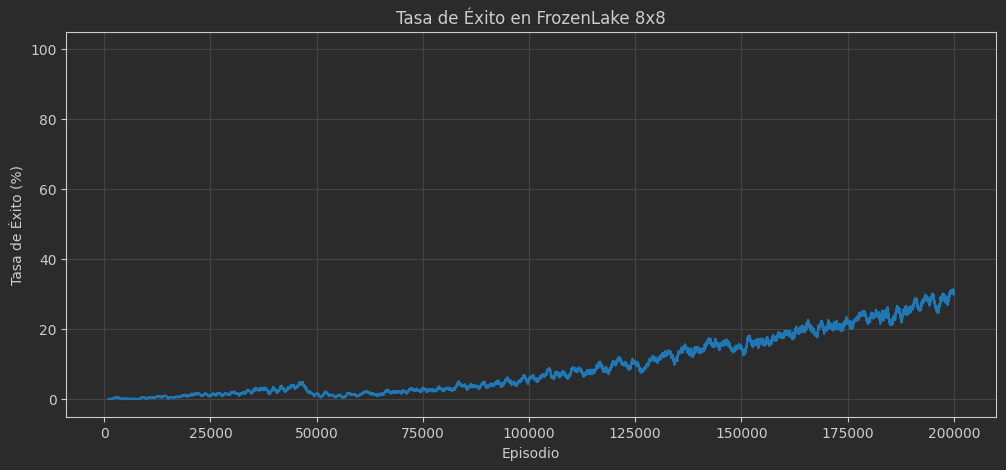

In [195]:
# 1. Gráfica de Convergencia (Tasa de Éxito con Media Móvil)
moving_avg_window = 1000    # Ventana para la media móvil en la gráfica
episodes = 200000
if len(rewards_all_episodes) >= moving_avg_window:
    # Calcular tasa de éxito (1 si recompensa > 0)
    success_rate_all = [1 if r > 0 else 0 for r in rewards_all_episodes]
    # Calcular media móvil
    moving_avg_success = np.convolve(success_rate_all, np.ones(moving_avg_window)/moving_avg_window, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(moving_avg_window - 1, episodes), moving_avg_success * 100)
    plt.title(f"Tasa de Éxito en FrozenLake 8x8")
    plt.xlabel("Episodio")
    plt.ylabel("Tasa de Éxito (%)")
    plt.grid(True)
    plt.ylim(-5, 105)
    plt.show()
else:
    print("No hay suficientes episodios para calcular la media móvil.")
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_all_episodes)
    plt.title("Recompensa por Episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa Total")
    plt.grid(True)
    plt.show()


Observamos la trayectoria aprendida

In [197]:
_,_,_,_ = run_q_learning_frozen_lake_8x8(3, is_training=False, render=True)

## Comparación: FrozenLake 4x4 vs FrozenLake 8x8

Los experimentos muestran una diferencia importante entre los entornos **FrozenLake 4x4** y **FrozenLake 8x8** al aplicar Q-Learning:

- En **FrozenLake 4x4**, el espacio de estados es relativamente pequeño (16 estados), por lo que el agente puede aprender una política razonable en un número moderado de episodios.  
- En **FrozenLake 8x8**, el espacio de estados crece a 64, lo que multiplica la complejidad del problema y hace que el aprendizaje con Q-Learning sea **mucho más lento** y menos eficiente. Incluso con cientos de miles de episodios, la tasa de éxito se mantiene baja y la convergencia es muy gradual.

### Limitación de Q-Learning
El enfoque tabular de Q-Learning guarda un valor Q para cada par estado-acción.  
Esto lo vuelve **poco escalable** cuando:
- El número de estados crece (espacios grandes o continuos).  
- Se requiere un entrenamiento más generalizado.  

En consecuencia, Q-Learning es útil como algoritmo introductorio y en entornos pequeños, pero sus limitaciones se hacen evidentes en escenarios más complejos.

### Una solución posible: Deep Q-Learning
Para superar estas limitaciones, se utiliza **Deep Q-Learning (DQN)**.  
En lugar de almacenar una tabla Q, DQN emplea una **red neuronal** para aproximar la función Q. Esto permite:
- Generalizar entre estados similares.  
- Escalar a entornos con espacios de estado mucho más grandes (incluso continuos).  
- Reducir la dependencia en el número exacto de estados.

Por estas razones, DQN se presenta como una alternativa más adecuada para entornos como **FrozenLake 8x8** o problemas aún más complejos.


# Deep Q-learning (DQN)


Este método surge como una extensión de Q-Learning para superar sus limitaciones en entornos con espacios de estados grandes o continuos.  
Mientras que Q-Learning almacena una tabla con los valores Q para cada par estado-acción, en DQN se utiliza una red neuronal para aproximar la función Q:

$$
Q(s,a) \approx Q(s,a;\theta)
$$

donde ( $\theta$) son los parámetros (pesos) de la red.

### Elementos clave de DQN
1. Red principal (policy network): recibe como entrada el estado del entorno y devuelve los valores Q de todas las acciones posibles.  
2. Experience Replay: las transiciones \((s, a, r, s')\) se almacenan en un buffer y se entrenan en lotes aleatorios. Esto rompe la correlación temporal entre experiencias y mejora la estabilidad del aprendizaje.  
3. Red objetivo (Target Network): se utiliza una segunda red (copia retardada de la red principal) para calcular los valores objetivo. Esto evita que los mismos parámetros se usen tanto para predecir como para actualizar, lo que estabiliza aún más el entrenamiento.  

Entre las ventajas que DQN presenta, podemos enumerar:

- Escalable a entornos mucho más grandes (e incluso continuos).  
- Capaz de generalizar entre estados similares gracias a la función de aproximación no lineal de las redes neuronales.  
- Superó hitos importantes, como jugar videojuegos de Atari directamente a partir de píxeles.  

En el caso de *FrozenLake*, DQN permite que el agente aprenda de forma más eficiente en el tablero 8x8, donde Q-Learning tabular muestra claras dificultades para converger.


**Definimos las clases de la red neuronal (DQN) y el banco de memoria (Replay Memory)**

In [289]:
class DQN(nn.Module):

    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Definimos una red con solamente una capa oculta
        self.fc1 = nn.Linear(in_states, h1_nodes)   # capa oculta (fully connected)
        self.out = nn.Linear(h1_nodes, out_actions) # capa de salida (acciones = 4)

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Se utiliza ReLu como función de activacion
        x = self.out(x)        
        return x
    
    '''
    Convierte un estado en una representacion tensorial.
    For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15. 
    Por ejemplo, en FrozenLake 4x4, existen 16 estados (del 0 al 15). Entonces:
    
    In: 
        state=2, n_states=16
    Return: 
        tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, n_states:int)->torch.Tensor:
        input_tensor = torch.zeros(n_states)
        input_tensor[state] = 1
        return input_tensor
    

    # Imprimir Red
    def print_dqn(self, actions):
        n_states = self.fc1.in_features
        for s in range(n_states):
            q_values = ''
            for q in self(self.state_to_dqn_input(s, n_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  
            q_values=q_values.rstrip()              

            best_action = actions[self(self.state_to_dqn_input(s, n_states)).argmax()]
            print(f'{s:02},{best_action},[{q_values}]', end=' ')         
            if (s+1)%1==0:
                print()

In [290]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

Definimos una clase para Deep Q-Learning que contenga a los procedimientos de entrenamiento (train), optimización (optimize), testeo (test) y presentación de resultados (print_dqn).

Para este caso tenemos una serie de hiperparametros extra que podemos definir:
 - Learning rate (alpha), tasa de aprendizaje, tambien utilizado en Q-learning.
 - Discount rate (gamma), factor de descuento que determina la importancia de la recompensa futura.
 - Sync rate, tasa de sincronismo, cantidad de iteraciones antes de actualizar la red principal a traves de la red objetivo.
 - replay_memory_size, tamaño del banco de memoria.
 - mini_batch_size, tamaño del mini batch para entrenamiento

## FrozenLake 4x4

In [291]:
class FrozenLakeDQL_4x4():
    
    # Hiperparametros

    learning_rate_a = 0.001         
    discount_factor_g = 0.9             
    network_sync_rate = 10          
    replay_memory_size = 1000       
    batch_size = 32                 

    # Parámetros de la red neuronal
    loss_fn = nn.MSELoss()          
    optimizer = None                
    ACTIONS = ['L','D','R','U']     

    # Exploración (Epsilon-Greedy)
    epsilon = 1.0              # Tasa de exploración inicial (100% aleatorio)
    max_epsilon = 1.0          # Máximo valor de epsilon
    min_epsilon = 0.01         # Mínimo valor de epsilon
    epsilon_decay_rate = 0.001 # Tasa de decaimiento de epsilon por episodio

    elapsed_time = 0

    # Estructuras para guardar recompensas y pasos por episodio
    rewards_all_episodes = []
    steps_all_episodes = []

    def train(self, episodes, render=False, is_slippery=False,verbose = False):

        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        
        memory = ReplayMemory(self.replay_memory_size)

        # 1. Creación de la red principal y la red objetivo
        prinicpal_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions)
        target_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions)

        # 2. Asegurarse que ambas redes sean iguales
        target_dqn.load_state_dict(prinicpal_dqn.state_dict())

        print('Red principal (antes de entrenamiento):')
        prinicpal_dqn.print_dqn(actions=self.ACTIONS)
        print('-'*40)
        
        # Seteamos el optimizador en Adam
        self.optimizer = torch.optim.Adam(prinicpal_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = np.zeros(episodes)
        epsilon_history = []

        report_interval = episodes // 20 # Cada cuántos episodios mostrar progreso

        # Contador de pasos para el sincronismo de las redes.
        step_count=0
        start_time = time.time()
        for episode in range(episodes):
            
            # reiniciar el entorno
            state,info = env.reset()  
            terminated = False      
            truncated = False
            total_reward_episode = 0
            steps_episode = 0    

            while(not terminated and not truncated):
                
                # 1. Elegir accion (epsilon-greedy) solamente durante entrenamiento
                if random.random() < self.epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = prinicpal_dqn(self.state_to_dqn_input(state, n_states)).argmax().item()

                # 2. Ejecutar accion
                new_state,reward,terminated,truncated,_ = env.step(action)

                # 3. Guardar experiencia en la memoria
                memory.append((state, action, new_state, reward, terminated)) 

                
                state = new_state
                step_count+=1
                total_reward_episode += reward

            # 5. Guardo informacion
            self.rewards_all_episodes.append(total_reward_episode)
            self.steps_all_episodes.append(step_count)

            # Verifica que tenga sufuciente "experiencia recolatada" y una recompensa
            if len(memory)>self.batch_size and np.sum(self.rewards_all_episodes)>0:
              
                mini_batch = memory.sample(self.batch_size)
                self.optimize(mini_batch, prinicpal_dqn, target_dqn)        

                # Decaimiento de Epsilon (exponencial)
                self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.epsilon_decay_rate * episode)
                epsilon_history.append(self.epsilon)

                # Sincronizacion de redes
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(prinicpal_dqn.state_dict())
                    step_count=0
            # 6. Reportar progreso
            if verbose:
                if (episode + 1) % report_interval == 0:
                    # Calcular tasa de éxito reciente
                    recent_episodes = self.rewards_all_episodes[-report_interval:]
                    success_rate = np.mean([1 if r > 0 else 0 for r in recent_episodes]) * 100
                    avg_steps = np.mean(self.steps_all_episodes[-report_interval:])
                    print(f"Episodio: {episode+1:>5}/{episodes} | "
                        f"Tasa Éxito (últimos {report_interval}): {success_rate:>6.2f}% | "
                        f"Pasos Prom (últimos {report_interval}): {avg_steps:>6.1f} | "
                        f"Epsilon: {self.epsilon:.3f}")

        env.close()
        end_time = time.time()

        self.elapsed_time = end_time - start_time

        # Guardamos la red principal
        torch.save(prinicpal_dqn.state_dict(), "frozen_lake_dql_4x4.pt")

    # Obtener resultados
    def get_results(self):
        return self.rewards_all_episodes,self.steps_all_episodes,self.elapsed_time
    
    # Optimizacion de la red principal
    def optimize(self, mini_batch, prinicpal_dqn, target_dqn):

        n_states = prinicpal_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                # Calcular el q-value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, n_states)).max()
                    )

            current_q = prinicpal_dqn(self.state_to_dqn_input(state, n_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, n_states)) 
            target_q[action] = target

            target_q_list.append(target_q)
                
        # Computar la funcion de perdida del minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Convierte un estado en una representacion tensorial.
    Por ejemplo, en FrozenLake 4x4, existen 16 estados (del 0 al 15). Entonces:
    Parametros: 
        state=2, n_states=16
    Return: 
        tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, n_states:int)->torch.Tensor:
        input_tensor = torch.zeros(n_states)
        input_tensor[state] = 1
        return input_tensor

    # Procedimiento para correr el ambiente con la red ya entrenada
    def test(self, episodes, is_slippery=False):

        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        n_states = env.observation_space.n
        n_actions = env.action_space.n

        # Cargar la red prinicipal
        prinicpal_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions) 
        prinicpal_dqn.load_state_dict(torch.load("frozen_lake_dql_4x4.pt"))
        prinicpal_dqn.eval()  

        print('Red principal (entrenada):')
        prinicpal_dqn.print_dqn(actions=self.ACTIONS)

        for episode in range(episodes):
            state,info = env.reset()
            terminated = False      
            truncated = False             

            # Navegar siempre con la politica greedy
            while(not terminated and not truncated):  
                with torch.no_grad():
                    action = prinicpal_dqn(self.state_to_dqn_input(state, n_states)).argmax().item()

                # Ejecutar action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()



In [292]:
frozen_lake = FrozenLakeDQL_4x4()
is_slippery = False
frozen_lake.train(20000, is_slippery=is_slippery,verbose=True)


Red principal (antes de entrenamiento):
00,U,[-0.18 -0.24 +0.09 +0.09] 
01,U,[-0.10 -0.24 +0.12 +0.17] 
02,R,[-0.22 -0.24 +0.13 +0.09] 
03,R,[-0.22 -0.20 +0.08 +0.01] 
04,R,[-0.25 -0.31 +0.09 +0.04] 
05,U,[-0.09 -0.27 +0.09 +0.15] 
06,R,[-0.06 -0.37 +0.14 -0.03] 
07,U,[-0.14 -0.21 +0.13 +0.13] 
08,R,[-0.16 -0.24 +0.08 +0.05] 
09,R,[-0.13 -0.22 +0.17 +0.10] 
10,U,[-0.16 -0.15 +0.15 +0.17] 
11,R,[-0.07 -0.27 +0.14 +0.01] 
12,U,[-0.07 -0.18 +0.14 +0.21] 
13,U,[-0.22 -0.19 +0.06 +0.14] 
14,R,[-0.04 -0.25 +0.19 +0.04] 
15,R,[-0.14 -0.36 +0.14 -0.02] 
----------------------------------------
Episodio:  1000/20000 | Tasa Éxito (últimos 1000):  25.30% | Pasos Prom (últimos 1000):   17.2 | Epsilon: 0.375
Episodio:  2000/20000 | Tasa Éxito (últimos 1000):  72.70% | Pasos Prom (últimos 1000):   10.1 | Epsilon: 0.144
Episodio:  3000/20000 | Tasa Éxito (últimos 1000):  89.10% | Pasos Prom (últimos 1000):    9.6 | Epsilon: 0.059
Episodio:  4000/20000 | Tasa Éxito (últimos 1000):  95.40% | Pasos Prom

In [293]:
frozen_lake.test(3, is_slippery=is_slippery)

Red principal (entrenada):
00,D,[+0.52 +0.59 +0.59 +0.54] 
01,R,[+0.52 +0.01 +0.66 +0.56] 
02,D,[+0.58 +0.74 +0.56 +0.65] 
03,L,[+0.65 +0.13 +0.60 +0.63] 
04,D,[+0.60 +0.66 +0.01 +0.52] 
05,U,[+0.49 +0.44 +0.55 +0.65] 
06,D,[+0.02 +0.81 +0.08 +0.64] 
07,U,[+0.45 +0.49 +0.49 +0.59] 
08,R,[+0.64 +0.03 +0.74 +0.57] 
09,R,[+0.66 +0.81 +0.81 +0.01] 
10,D,[+0.74 +0.90 +0.01 +0.73] 
11,D,[+0.49 +0.59 +0.49 +0.51] 
12,D,[+0.53 +0.65 +0.38 +0.48] 
13,R,[-0.02 +0.80 +0.90 +0.78] 
14,R,[+0.83 +0.89 +1.00 +0.81] 
15,U,[+0.13 +0.29 +0.52 +0.52] 


Al finalizar podemos observar la trayectoria aprendida, junto con las métricas de tasa de éxito, pasos promedio y tiempo total:
- El agente logra una tasa de éxito muy alta (93%), mostrando que DQN es capaz de aprender una política eficiente en este entorno sencillo.  
- El número promedio de pasos por episodio (9.6) indica que el agente encontró trayectorias relativamente cortas y consistentes hacia el objetivo.  
- Aunque el tiempo de entrenamiento es mayor que en Q-Learning tabular, el desempeño final es claramente superior en términos de estabilidad y tasa de éxito.  

In [294]:
rewards_all_episodes,steps_all_episodes,elapsed_time = frozen_lake.get_results()

success_rate = np.mean([1 if r > 0 else 0 for r in rewards_all_episodes]) * 100
avg_steps = np.mean(steps_all_episodes)
print(  f"Tasa Éxito: {success_rate:>6.2f}% | "
        f"Pasos Prom: {avg_steps:>6.1f} | "
        f"Tiempo total:{elapsed_time:.2f} segundos.")

Tasa Éxito:  93.19% | Pasos Prom:    9.6 | Tiempo total:176.34 segundos.


Si graficamos la tasa de éxito del modelo, se observa que a paritr de los 4000 episodios, la misma converge a un valor cercano al 100% lo que indica que el algoritmo ya aprendio correctamente el mapa y lo tiene refleajo en la red neuronal.

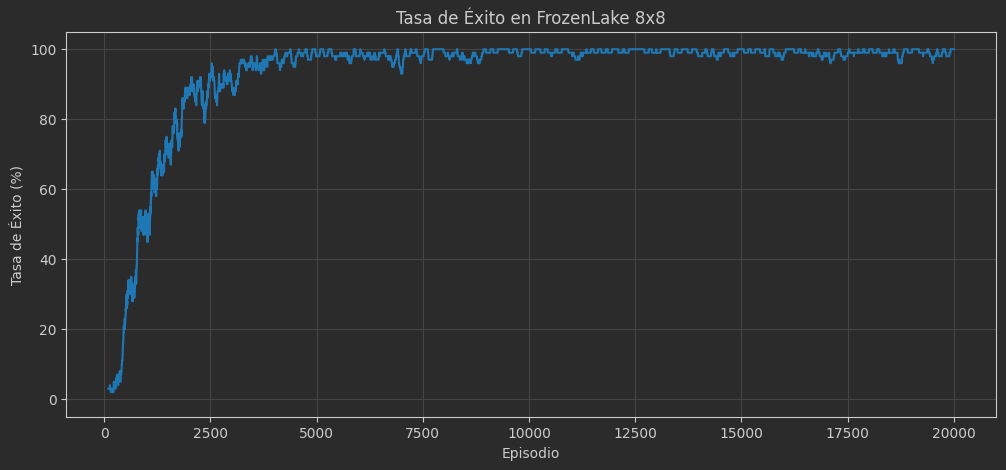

In [296]:
# 1. Gráfica de Convergencia (Tasa de Éxito con Media Móvil)
moving_avg_window = 100    # Ventana para la media móvil en la gráfica
episodes = 20000
if len(rewards_all_episodes) >= moving_avg_window:
    # Calcular tasa de éxito (1 si recompensa > 0)
    success_rate_all = [1 if r > 0 else 0 for r in rewards_all_episodes]
    # Calcular media móvil
    moving_avg_success = np.convolve(success_rate_all, np.ones(moving_avg_window)/moving_avg_window, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(moving_avg_window - 1, episodes), moving_avg_success * 100)
    plt.title(f"Tasa de Éxito en FrozenLake 8x8")
    plt.xlabel("Episodio")
    plt.ylabel("Tasa de Éxito (%)")
    plt.grid(True)
    plt.ylim(-5, 105)
    plt.show()
else:
    print("No hay suficientes episodios para calcular la media móvil.")
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_all_episodes)
    plt.title("Recompensa por Episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa Total")
    plt.grid(True)
    plt.show()


## FrozenLake 8x8

Para analizar el comportamiento de DQN de manera mas exhaustiva, se utiliza una expansion del ambiente de frozenlake de 4x4 a 8x8, para observar la performance del modelo en un ambiente significativamente más grande. 

In [279]:
class FrozenLakeDQL_8x8():
    
    # Hiperparametros

    learning_rate_a = 0.001         
    discount_factor_g = 0.9             
    network_sync_rate = 10          
    replay_memory_size = 1000       
    batch_size = 32                 

    # Parámetros de la red neuronal
    loss_fn = nn.MSELoss()          
    optimizer = None                
    ACTIONS = ['L','D','R','U']     

    # Exploración (Epsilon-Greedy)
    epsilon = 1.0              # Tasa de exploración inicial (100% aleatorio)
    max_epsilon = 1.0          # Máximo valor de epsilon
    min_epsilon = 0.01         # Mínimo valor de epsilon
    epsilon_decay_rate = 0.001 # Tasa de decaimiento de epsilon por episodio

    elapsed_time = 0

    # Estructuras para guardar recompensas y pasos por episodio
    rewards_all_episodes = []
    steps_all_episodes = []

    def train(self, episodes, render=False, is_slippery=False,verbose = False):

        env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=is_slippery, render_mode='human' if render else None)
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        
        memory = ReplayMemory(self.replay_memory_size)

        # 1. Creación de la red principal y la red objetivo
        prinicpal_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions)
        target_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions)

        # 2. Asegurarse que ambas redes sean iguales
        target_dqn.load_state_dict(prinicpal_dqn.state_dict())

        print('Red principal (antes de entrenamiento):')
        prinicpal_dqn.print_dqn(actions=self.ACTIONS)
        print('-'*40)
        
        # Seteamos el optimizador en Adam
        self.optimizer = torch.optim.Adam(prinicpal_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = np.zeros(episodes)
        epsilon_history = []

        report_interval = episodes // 20 # Cada cuántos episodios mostrar progreso

        # Contador de pasos para el sincronismo de las redes.
        step_count=0
        start_time = time.time()
        for episode in range(episodes):
            
            # reiniciar el entorno
            state,info = env.reset()  
            terminated = False      
            truncated = False
            total_reward_episode = 0
            steps_episode = 0    

            while(not terminated and not truncated):
                
                # 1. Elegir accion (epsilon-greedy) solamente durante entrenamiento
                if random.random() < self.epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = prinicpal_dqn(self.state_to_dqn_input(state, n_states)).argmax().item()

                # 2. Ejecutar accion
                new_state,reward,terminated,truncated,_ = env.step(action)

                # 3. Guardar experiencia en la memoria
                memory.append((state, action, new_state, reward, terminated)) 

                
                state = new_state
                step_count+=1
                total_reward_episode += reward

            # 5. Guardo informacion
            self.rewards_all_episodes.append(total_reward_episode)
            self.steps_all_episodes.append(step_count)

            # Verifica que tenga sufuciente "experiencia recolatada" y una recompensa
            if len(memory)>self.batch_size and np.sum(self.rewards_all_episodes)>0:
              
                mini_batch = memory.sample(self.batch_size)
                self.optimize(mini_batch, prinicpal_dqn, target_dqn)        

                # Decaimiento de Epsilon (exponencial)
                self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.epsilon_decay_rate * episode)
                epsilon_history.append(self.epsilon)

                # Sincronizacion de redes
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(prinicpal_dqn.state_dict())
                    step_count=0
            # 6. Reportar progreso
            if verbose:
                if (episode + 1) % report_interval == 0:
                    # Calcular tasa de éxito reciente
                    recent_episodes = self.rewards_all_episodes[-report_interval:]
                    success_rate = np.mean([1 if r > 0 else 0 for r in recent_episodes]) * 100
                    avg_steps = np.mean(self.steps_all_episodes[-report_interval:])
                    print(f"Episodio: {episode+1:>5}/{episodes} | "
                        f"Tasa Éxito (últimos {report_interval}): {success_rate:>6.2f}% | "
                        f"Pasos Prom (últimos {report_interval}): {avg_steps:>6.1f} | "
                        f"Epsilon: {self.epsilon:.3f}")

        env.close()
        end_time = time.time()

        self.elapsed_time = end_time - start_time

        # Guardamos la red principal
        torch.save(prinicpal_dqn.state_dict(), "frozen_lake_dql_8x8.pt")

    # Obtener resultados
    def get_results(self):
        return self.rewards_all_episodes,self.steps_all_episodes,self.elapsed_time
    
    # Optimizacion de la red principal
    def optimize(self, mini_batch, prinicpal_dqn, target_dqn):

        n_states = prinicpal_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                # Calcular el q-value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, n_states)).max()
                    )

            current_q = prinicpal_dqn(self.state_to_dqn_input(state, n_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, n_states)) 
            target_q[action] = target

            target_q_list.append(target_q)
                
        # Computar la funcion de perdida del minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Convierte un estado en una representacion tensorial.
    Por ejemplo, en FrozenLake 8x8, existen 16 estados (del 0 al 15). Entonces:
    Parametros: 
        state=2, n_states=16
    Return: 
        tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, n_states:int)->torch.Tensor:
        input_tensor = torch.zeros(n_states)
        input_tensor[state] = 1
        return input_tensor

    # Procedimiento para correr el ambiente con la red ya entrenada
    def test(self, episodes, is_slippery=False):

        env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=is_slippery, render_mode='human')
        n_states = env.observation_space.n
        n_actions = env.action_space.n

        # Cargar la red prinicipal
        prinicpal_dqn = DQN(in_states=n_states, h1_nodes=n_states, out_actions=n_actions) 
        prinicpal_dqn.load_state_dict(torch.load("frozen_lake_dql_8x8.pt"))
        prinicpal_dqn.eval()  

        print('Red principal (entrenada):')
        prinicpal_dqn.print_dqn(actions=self.ACTIONS)

        for episode in range(episodes):
            state,info = env.reset()
            terminated = False      
            truncated = False             

            # Navegar siempre con la politica greedy
            while(not terminated and not truncated):  
                with torch.no_grad():
                    action = prinicpal_dqn(self.state_to_dqn_input(state, n_states)).argmax().item()

                # Ejecutar action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()



In [280]:
frozen_lake = FrozenLakeDQL_8x8()
is_slippery = False
frozen_lake.train(5000, is_slippery=is_slippery,verbose=True)

Red principal (antes de entrenamiento):
00,U,[-0.10 +0.01 -0.03 +0.05] 
01,U,[-0.11 -0.03 -0.02 -0.00] 
02,U,[-0.06 -0.01 +0.06 +0.07] 
03,U,[-0.06 -0.01 -0.04 +0.08] 
04,U,[-0.08 +0.01 +0.01 +0.04] 
05,U,[-0.09 -0.05 +0.01 +0.07] 
06,U,[-0.07 -0.02 -0.01 +0.05] 
07,U,[-0.04 -0.02 +0.05 +0.06] 
08,U,[-0.13 -0.06 -0.01 +0.09] 
09,U,[-0.08 -0.08 -0.00 +0.09] 
10,R,[-0.10 -0.01 +0.02 -0.02] 
11,U,[-0.06 -0.00 +0.01 +0.05] 
12,U,[-0.10 -0.03 -0.02 +0.07] 
13,U,[-0.06 +0.01 +0.04 +0.06] 
14,R,[-0.07 -0.04 +0.04 +0.03] 
15,U,[-0.07 -0.01 -0.02 +0.06] 
16,U,[-0.14 -0.01 +0.01 +0.01] 
17,U,[-0.08 -0.07 -0.00 +0.08] 
18,U,[-0.11 -0.03 -0.04 +0.04] 
19,U,[-0.13 -0.01 -0.05 +0.09] 
20,U,[-0.12 -0.06 -0.00 +0.07] 
21,U,[-0.09 -0.06 -0.01 +0.01] 
22,U,[-0.08 -0.10 -0.05 +0.06] 
23,U,[-0.14 -0.04 -0.03 +0.04] 
24,U,[-0.08 -0.06 -0.02 +0.15] 
25,U,[-0.11 -0.04 +0.02 +0.07] 
26,U,[-0.07 -0.03 -0.01 +0.07] 
27,U,[-0.09 -0.02 +0.02 +0.03] 
28,U,[-0.09 -0.06 -0.04 +0.08] 
29,U,[-0.06 -0.04 -0.02 +0.05] 


In [288]:
frozen_lake.test(3, is_slippery=is_slippery)

Red principal (entrenada):
00,R,[+0.21 +0.24 +0.24 +0.23] 
01,D,[+0.23 +0.29 +0.28 +0.26] 
02,D,[+0.26 +0.32 +0.32 +0.29] 
03,D,[+0.30 +0.34 +0.33 +0.31] 
04,R,[+0.30 +0.36 +0.38 +0.35] 
05,D,[+0.34 +0.43 +0.42 +0.38] 
06,D,[+0.37 +0.48 +0.46 +0.42] 
07,D,[+0.42 +0.53 +0.47 +0.44] 
08,R,[+0.23 +0.26 +0.28 +0.24] 
09,R,[+0.24 +0.27 +0.30 +0.25] 
10,R,[+0.27 +0.26 +0.32 +0.28] 
11,R,[+0.33 +0.00 +0.34 +0.30] 
12,D,[+0.34 +0.44 +0.43 +0.36] 
13,D,[+0.37 +0.48 +0.48 +0.40] 
14,D,[+0.43 +0.54 +0.51 +0.44] 
15,D,[+0.46 +0.59 +0.51 +0.47] 
16,U,[+0.19 +0.21 +0.23 +0.24] 
17,R,[+0.22 +0.22 +0.23 +0.22] 
18,U,[+0.21 +0.20 +0.20 +0.30] 
19,D,[+0.13 +0.44 +0.41 +0.39] 
20,R,[+0.03 +0.41 +0.50 +0.42] 
21,R,[+0.43 +0.04 +0.52 +0.44] 
22,D,[+0.47 +0.59 +0.57 +0.48] 
23,D,[+0.52 +0.66 +0.57 +0.53] 
24,R,[+0.18 +0.22 +0.24 +0.24] 
25,R,[+0.17 +0.28 +0.28 +0.28] 
26,U,[+0.21 +0.30 +0.30 +0.32] 
27,L,[+0.26 +0.13 +0.24 +0.08] 
28,U,[+0.20 +0.33 +0.37 +0.45] 
29,D,[+0.27 +0.41 +0.40 +0.37] 
30,R,[+0.02 +

Al aplicar *Deep Q-Learning* (DQN) en *FrozenLake 8x8* y entrenar por solo 5000 episodios (un cuarto de los 20000 episodios usados en el caso de *FrozenLake 4x4*), se obtuvieron los siguientes resultados finales:

- Tasa de éxito: 67.02%  
- Promedio de pasos por episodio: 2435.1  
- Tiempo total de entrenamiento: 39.02 segundos  

Esto evidencia que durante el proceso de aprendizaje, el agente mostró una clara mejora progresiva:

- Al inicio (primeros 1000 episodios) la tasa de éxito era prácticamente nula, con trayectorias extremadamente largas (más de 10.000 pasos en promedio).  
- A partir de los 1250 episodios, el agente comenzó a estabilizar sus trayectorias y alcanzó un 39% de éxito, con episodios más cortos (~45 pasos).  
- Desde los 2000 episodios en adelante, la tasa de éxito superó el 85%, y las trayectorias se redujeron a menos de 20 pasos en promedio.  
- En las últimas iteraciones (≈5000 episodios) el agente alcanzó un 98.8% de éxito, resolviendo consistentemente el entorno con trayectorias óptimas (~14 pasos).  

En comparación con FrozenLake 4x4, en *FrozenLake 8x8*, con solo 5000 episodios (un cuarto de la cantidad usada en 4x4), el agente alcanzó un 98.8% de éxito en la fase final del entrenamiento.  

Esto evidencia que, aunque el entorno más grande es inicialmente más complejo y el agente necesita explorar mucho más, DQN logra escalar exitosamente a entornos de mayor dimensión, algo que no es posible con Q-Learning tabular.  

En resumen, DQN no solo resuelve *FrozenLake 4x4* de manera eficiente, sino que también muestra un fuerte potencial de generalización y escalabilidad en el caso de *FrozenLake 8x8*.


In [284]:
rewards_all_episodes,steps_all_episodes,elapsed_time = frozen_lake.get_results()

success_rate = np.mean([1 if r > 0 else 0 for r in rewards_all_episodes]) * 100
avg_steps = np.mean(steps_all_episodes)
print(  f"Tasa Éxito: {success_rate:>6.2f}% | "
        f"Pasos Prom: {avg_steps:>6.1f} | "
        f"Tiempo total:{elapsed_time:.2f} segundos.")

Tasa Éxito:  67.02% | Pasos Prom: 2435.1 | Tiempo total:39.02 segundos.


Si graficamos la tasa de éxito del modelo, se observa que a paritr de los 2000 episodios, la misma converge a un valor cercano al 100% lo que indica que el algoritmo ya aprendio correctamente el mapa y lo tiene refleajo en la red neuronal.

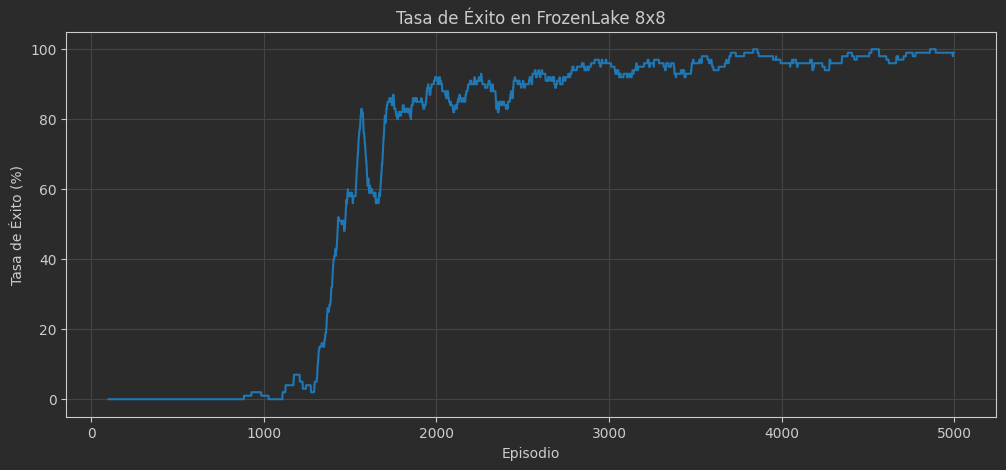

In [287]:
# 1. Gráfica de Convergencia (Tasa de Éxito con Media Móvil)
moving_avg_window = 100    # Ventana para la media móvil en la gráfica
episodes = 5000
if len(rewards_all_episodes) >= moving_avg_window:
    # Calcular tasa de éxito (1 si recompensa > 0)
    success_rate_all = [1 if r > 0 else 0 for r in rewards_all_episodes]
    # Calcular media móvil
    moving_avg_success = np.convolve(success_rate_all, np.ones(moving_avg_window)/moving_avg_window, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(moving_avg_window - 1, episodes), moving_avg_success * 100)
    plt.title(f"Tasa de Éxito en FrozenLake 8x8")
    plt.xlabel("Episodio")
    plt.ylabel("Tasa de Éxito (%)")
    plt.grid(True)
    plt.ylim(-5, 105)
    plt.show()
else:
    print("No hay suficientes episodios para calcular la media móvil.")
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_all_episodes)
    plt.title("Recompensa por Episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa Total")
    plt.grid(True)
    plt.show()
